In [24]:
# import package
import numpy as np
import os
import collections
import argparse
# import librosa
import random
import torch
# import heapq
import glob
import csv
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
# import torchvision.models as models
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [76]:
data = np.load('/mnt/gestalt/home/lonian/datasets/mamba_test_token/1.npy', allow_pickle=True)
K, L = data.shape
a = np.zeros((K*L))
for i in range(K*L):
    a[i] = data[i%4, i//4]

In [32]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class Dataset(object):
    def __init__(self, datalist) -> None:
        self.data_path = datalist
    
    def __getitem__(self, idx):
        # shape = [1, 128, slice_length]
        path = self.data_path[idx]
        data = np.load(path, allow_pickle=True)
        K, L = data.shape
        a = np.zeros((K*L))
        for i in range(K*L):
            a[i] = data[i%4, i//4]
        return 	torch.LongTensor(a)
    
    def __len__(self):
        return len(self.data_path)

In [33]:
from glob import glob
path = glob('/mnt/gestalt/home/lonian/datasets/mamba_test_token/*.npy')
# Dataset(path)
print(len(path))
train_data = Dataset(path)
train_loader = DataLoader(dataset=train_data, batch_size = 8, shuffle=True)

1746


In [1]:
from transformers import MambaConfig, MambaModel
from torch import nn
class ScaledEmbedding(nn.Embedding):
    """Boost learning rate for embeddings (with `scale`).
    """
    def __init__(self, *args, lr=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr

    def make_optim_group(self):
        group = {"params": list(self.parameters())}
        if self.lr is not None:
            group["lr"] = self.lr
        return group

class Musicmamba(nn.Module):
    def __init__(self):
        super(Musicmamba, self).__init__()
        # parameters setup
        self.card = 2048
        embed_dim = self.card
        self.dim = 1024
        self.token_layer = 4
    
        configuration = MambaConfig(
            vocab_size = self.card,
            hidden_size = self.dim
        )
        
        self.emb = nn.ModuleList([ScaledEmbedding(embed_dim, self.dim) for _ in range(self.token_layer)])
        # self.model = MambaModel(configuration)
        # self.layers = []
        # for _ in range(64):
        #     self.layers.append(MambaModel(configuration).layers[0])
        # self.layers = nn.ModuleList(self.layers)
        self.layers = nn.ModuleList([MambaModel(configuration).layers[0] for _ in range(64)])
        self.norm_f = MambaModel(configuration).norm_f
        
        self.linears = nn.ModuleList([nn.Linear(self.dim, self.card) for _ in range(self.token_layer)])

    def forward(self, sequence):
        # out = self.model(x)
        B, K, S = sequence.shape
        input_ = sum([self.emb[k](sequence[:, k]) for k in range(K)])
        for module in self.layers:
            input_ = module(input_)
            # print(out)
        out = self.norm_f(input_)
        logits = torch.stack([self.linears[k](out) for k in range(K)], dim=1)  # [B, K, S, card]
        return logits

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import torch

device = 'cpu'
model = Musicmamba()
# model = model.to(device)
# data = np.load('/mnt/gestalt/home/lonian/datasets/mamba_test_token/1.npy', allow_pickle=True)
# d = torch.LongTensor([data]).to(device)
# output = model(d)
# print(output.shape)

In [5]:
type(model.modules)

method

In [6]:
print(str(model.modules))

<bound method Module.modules of Musicmamba(
  (emb): ModuleList(
    (0-3): 4 x ScaledEmbedding(2048, 1024)
  )
  (layers): ModuleList(
    (0-63): 64 x MambaBlock(
      (norm): MambaRMSNorm()
      (mixer): MambaMixer(
        (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
        (act): SiLU()
        (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
        (x_proj): Linear(in_features=2048, out_features=96, bias=False)
        (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
        (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
      )
    )
  )
  (norm_f): MambaRMSNorm()
  (linears): ModuleList(
    (0-3): 4 x Linear(in_features=1024, out_features=2048, bias=True)
  )
)>


In [3]:
print(str(model.get_submodule))

<bound method Module.get_submodule of Musicmamba(
  (emb): ModuleList(
    (0-3): 4 x ScaledEmbedding(2048, 1024)
  )
  (layers): ModuleList(
    (0-63): 64 x MambaBlock(
      (norm): MambaRMSNorm()
      (mixer): MambaMixer(
        (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
        (act): SiLU()
        (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
        (x_proj): Linear(in_features=2048, out_features=96, bias=False)
        (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
        (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
      )
    )
  )
  (norm_f): MambaRMSNorm()
  (linears): ModuleList(
    (0-3): 4 x Linear(in_features=1024, out_features=2048, bias=True)
  )
)>


In [14]:
data.shape

(4, 1500)

In [4]:
a ="<bound method Module.get_submodule of Musicmamba(\n  (emb): ModuleList(\n    (0-3): 4 x ScaledEmbedding(2048, 1024)\n  )\n  (layers_1): ModuleList(\n    (0-31): 32 x MambaBlock(\n      (norm): MambaRMSNorm()\n      (mixer): MambaMixer(\n        (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)\n        (act): SiLU()\n        (in_proj): Linear(in_features=1024, out_features=4096, bias=False)\n        (x_proj): Linear(in_features=2048, out_features=96, bias=False)\n        (dt_proj): Linear(in_features=64, out_features=2048, bias=True)\n        (out_proj): Linear(in_features=2048, out_features=1024, bias=False)\n      )\n    )\n  )\n  (layers_2): ModuleList(\n    (0-31): 32 x MambaBlock(\n      (norm): MambaRMSNorm()\n      (mixer): MambaMixer(\n        (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)\n        (act): SiLU()\n        (in_proj): Linear(in_features=1024, out_features=4096, bias=False)\n        (x_proj): Linear(in_features=2048, out_features=96, bias=False)\n        (dt_proj): Linear(in_features=64, out_features=2048, bias=True)\n        (out_proj): Linear(in_features=2048, out_features=1024, bias=False)\n      )\n    )\n  )\n  (norm_f): MambaRMSNorm()\n  (linears): ModuleList(\n    (0-3): 4 x Linear(in_features=1024, out_features=2048, bias=True)\n  )\n)>"
print(a)

<bound method Module.get_submodule of Musicmamba(
  (emb): ModuleList(
    (0-3): 4 x ScaledEmbedding(2048, 1024)
  )
  (layers_1): ModuleList(
    (0-31): 32 x MambaBlock(
      (norm): MambaRMSNorm()
      (mixer): MambaMixer(
        (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
        (act): SiLU()
        (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
        (x_proj): Linear(in_features=2048, out_features=96, bias=False)
        (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
        (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
      )
    )
  )
  (layers_2): ModuleList(
    (0-31): 32 x MambaBlock(
      (norm): MambaRMSNorm()
      (mixer): MambaMixer(
        (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
        (act): SiLU()
        (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
        (x_proj): Linear(in_features=2

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-2.8b-hf")

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


In [5]:
model

MambaForCausalLM(
  (backbone): MambaModel(
    (embeddings): Embedding(50280, 2560)
    (layers): ModuleList(
      (0-63): 64 x MambaBlock(
        (norm): MambaRMSNorm()
        (mixer): MambaMixer(
          (conv1d): Conv1d(5120, 5120, kernel_size=(4,), stride=(1,), padding=(3,), groups=5120)
          (act): SiLU()
          (in_proj): Linear(in_features=2560, out_features=10240, bias=False)
          (x_proj): Linear(in_features=5120, out_features=192, bias=False)
          (dt_proj): Linear(in_features=160, out_features=5120, bias=True)
          (out_proj): Linear(in_features=5120, out_features=2560, bias=False)
        )
      )
    )
    (norm_f): MambaRMSNorm()
  )
  (lm_head): Linear(in_features=2560, out_features=50280, bias=False)
)

In [ ]:
print(model)

In [20]:
append = np.array([[4], [3], [2], [1]])
print(append.shape)

(4, 1)


In [26]:
prompt_seq = np.concatenate((data, append), axis=1)
print(prompt_seq.shape)

(4, 1501)


In [27]:
prompt_seq[:, -1]

array([4, 3, 2, 1])

In [93]:
a[0:-4].shape

(5996,)

In [95]:
a[-4:].shape

(4,)

In [94]:
a[4:].shape

(5996,)

In [91]:
data[:, :].shape

(4, 1500)

In [61]:
data

array([[ 778,  609,  609, ...,  289,  609,  289],
       [ 911, 1758, 1815, ..., 2044, 1931, 2044],
       [1747,  815, 1895, ..., 1509, 2021, 2003],
       [1770, 1350, 1951, ...,  368, 1854, 1394]])

In [56]:
from transformers import MambaConfig, MambaModel

# Initializing a Mamba configuration
configuration = MambaConfig(
    vocab_size = 2048,
    hidden_size = 1024
)

# Initializing a model (with random weights) from the configuration
model = MambaModel(configuration)

# Accessing the model configuration
configuration = model.config

In [13]:
def cal_torch_model_params(model):
    '''
    :param model:
    :return:
    '''
    # Find total parameters and trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'total_params': total_params/1000000, 'total_trainable_params': total_trainable_params/1000000}

print(cal_torch_model_params(model))

{'total_params': 232.236032, 'total_trainable_params': 232.236032}


In [2]:
model

MambaModel(
  (embeddings): Embedding(2048, 128)
  (layers): ModuleList(
    (0-31): 32 x MambaBlock(
      (norm): MambaRMSNorm()
      (mixer): MambaMixer(
        (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
        (act): SiLU()
        (in_proj): Linear(in_features=128, out_features=512, bias=False)
        (x_proj): Linear(in_features=256, out_features=40, bias=False)
        (dt_proj): Linear(in_features=8, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=128, bias=False)
      )
    )
  )
  (norm_f): MambaRMSNorm()
)

In [30]:
configuration

MambaConfig {
  "bos_token_id": 0,
  "conv_kernel": 4,
  "eos_token_id": 0,
  "expand": 2,
  "hidden_act": "silu",
  "hidden_size": 768,
  "initializer_range": 0.1,
  "intermediate_size": 1536,
  "layer_norm_epsilon": 1e-05,
  "model_type": "mamba",
  "num_hidden_layers": 32,
  "pad_token_id": 0,
  "rescale_prenorm_residual": false,
  "residual_in_fp32": true,
  "state_size": 16,
  "time_step_floor": 0.0001,
  "time_step_init_scheme": "random",
  "time_step_max": 0.1,
  "time_step_min": 0.001,
  "time_step_rank": 48,
  "time_step_scale": 1.0,
  "transformers_version": "4.41.2",
  "use_bias": false,
  "use_cache": true,
  "use_conv_bias": true,
  "vocab_size": 50280
}

In [39]:
model

MambaForCausalLM(
  (backbone): MambaModel(
    (embeddings): Embedding(50280, 768)
    (layers): ModuleList(
      (0-23): 24 x MambaBlock(
        (norm): MambaRMSNorm()
        (mixer): MambaMixer(
          (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
          (act): SiLU()
          (in_proj): Linear(in_features=768, out_features=3072, bias=False)
          (x_proj): Linear(in_features=1536, out_features=80, bias=False)
          (dt_proj): Linear(in_features=48, out_features=1536, bias=True)
          (out_proj): Linear(in_features=1536, out_features=768, bias=False)
        )
      )
    )
    (norm_f): MambaRMSNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50280, bias=False)
)

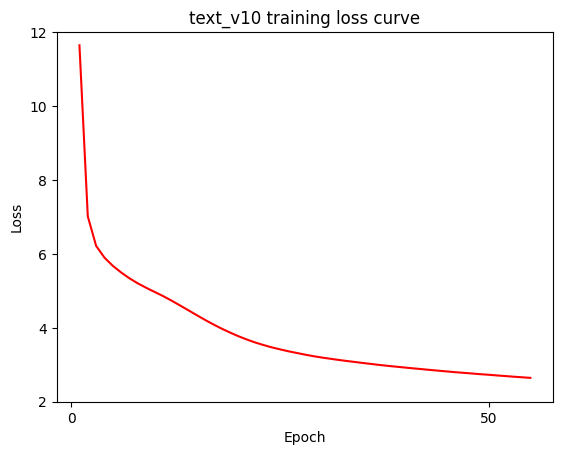

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
version = 'text_v10'
a = np.load('/mnt/gestalt/home/lonian/mamba/model/ckpts/{}/training_loss.npy'.format(version))
# a = a/4

#Example 1 Plot cos(x) between 0 and 2*pi
x = range(1, int(len(a)+1)) # 50x1 array between 0 and 2*pi
# y = np.cos(x)                  # cos(x)

x_major_locator=MultipleLocator(50)
y_major_locator=MultipleLocator(2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
# plt.xlim(0,200.5)
plt.ylim(2,12)

plt.plot(x, a, 'r')   # red line without marker
plt.title('{} training loss curve'.format(version))
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.show()
# plt.plot(x, a, 'b-o') # blue solid line with filled circle marker
plt.savefig('/mnt/gestalt/home/lonian/mamba/model/ckpts/{}/training_loss.png'.format(version))
plt.show()

In [3]:
for idx, aa in enumerate(a):
    print(idx+1, '\t', aa)

1 	 10.843802320805372
2 	 8.67422795440299
3 	 7.162676992381682
4 	 6.6798123815444255
5 	 6.400802315474279
6 	 6.205408804068933
7 	 6.053379916255586
8 	 5.928838266467528
9 	 5.826248675277553
10 	 5.743347564173367
11 	 5.671947523309941
12 	 5.60836360163946
13 	 5.552773988530664
14 	 5.503686438389733
15 	 5.4598516244791435
16 	 5.421443579285849
17 	 5.3862118587449075
18 	 5.354359612185135
19 	 5.324733899769601
20 	 5.297314636034269
21 	 5.271671598701494
22 	 5.247809229473984
23 	 5.225222253036759
24 	 5.203539178904943
25 	 5.183338814355736
26 	 5.1641546899329684
27 	 5.145740971881885
28 	 5.127981072740167
29 	 5.111010673517455
30 	 5.094686442826863
31 	 5.0788732587098355
32 	 5.0635885275931996
33 	 5.048985917019512
34 	 5.034665752552436
35 	 5.020727831280687
36 	 5.007200549287171
37 	 4.993606792427396
38 	 4.980864611790352
39 	 4.968111326200735
40 	 4.956007049942537
41 	 4.9435409280912594
42 	 4.931767256152203
43 	 4.919977108661589
44 	 4.9083984

In [6]:
import numpy as np
a = np.array([16.51710469, 11.21570262,  7.90007398,  7.17649954,  6.82042663,
        6.57737762,  6.4055388 ,  6.28017034,  6.17770326,  6.08869242,
        6.00751681,  5.93016965,  5.86258433,  5.80313026,  5.74896246,
        5.70094316,  5.65616513,  5.61368549,  5.57458321,  5.53725072,
        5.5017525 ,  5.46727222,  5.4338563 ,  5.40175269,  5.37063075,
        5.34136607,  5.31349127,  5.28703623,  5.26071534,  5.23604451,
        5.2121158 ,  5.18885966,  5.16776611,  5.14709215,  5.12755379,
        5.10880421,  5.09157544,  5.0744506 ,  5.05860186,  5.04306475,
        5.02840587,  5.01438547,  5.00111889,  4.98838885,
        4.97599844,  4.96390166,  4.95304892,  4.94146319,  4.93132942,
        4.92073443,  4.91115333,  4.90208731,  4.89247134,  4.88356306,
        4.87501706,  4.86657865,  4.85873804,  4.85045628,  4.84309226,
        4.83519033,  4.82857988,  4.82132158,  4.81396425,  4.80823474,
        4.80141706,  4.79496466,  4.78906058,  4.78314414,  4.77738829,
        4.77148051,  4.76594986,  4.7605493 ,  4.75529067,  4.75024984,
        4.74503159,  4.74034945,  4.73545502,  4.73069172,  4.72624295,
        4.72160338,  4.71697419,  4.71297348,  4.70872468,  4.70464878,
        4.70035578,  4.69626572])
a

array([16.51710469, 11.21570262,  7.90007398,  7.17649954,  6.82042663,
        6.57737762,  6.4055388 ,  6.28017034,  6.17770326,  6.08869242,
        6.00751681,  5.93016965,  5.86258433,  5.80313026,  5.74896246,
        5.70094316,  5.65616513,  5.61368549,  5.57458321,  5.53725072,
        5.5017525 ,  5.46727222,  5.4338563 ,  5.40175269,  5.37063075,
        5.34136607,  5.31349127,  5.28703623,  5.26071534,  5.23604451,
        5.2121158 ,  5.18885966,  5.16776611,  5.14709215,  5.12755379,
        5.10880421,  5.09157544,  5.0744506 ,  5.05860186,  5.04306475,
        5.02840587,  5.01438547,  5.00111889,  4.98838885,  4.97599844,
        4.96390166,  4.95304892,  4.94146319,  4.93132942,  4.92073443,
        4.91115333,  4.90208731,  4.89247134,  4.88356306,  4.87501706,
        4.86657865,  4.85873804,  4.85045628,  4.84309226,  4.83519033,
        4.82857988,  4.82132158,  4.81396425,  4.80823474,  4.80141706,
        4.79496466,  4.78906058,  4.78314414,  4.77738829,  4.77

In [1]:
import torch
import os
checkpoints_path = '/mnt/gestalt/home/lonian/mamba/model/ckpts/v18/epoch_042.pkl'
if os.path.isfile(checkpoints_path):
    checkpoint = torch.load(checkpoints_path, map_location='cpu')

In [2]:
checkpoint['loss']

5.014385472116688

In [6]:
len(a)

87

In [31]:
from mamba_ssm import Mamba2

batch, length, dim = 2, 64, 1024

x = torch.randn(batch, length, dim).to("cuda")

model = Mamba2(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=1024, # Model dimension d_model
    d_state=64,  # SSM state expansion factor, typically 64 or 128
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
).to("cuda")
y = model(x)
assert y.shape == x.shape

In [32]:
from mamba_ssm.ops.triton.layernorm_gated import RMSNorm as RMSNormGated, LayerNorm

In [33]:
from mamba_ssm.models.config_mamba import MambaConfig

In [36]:
a = MambaConfig()
a.d_model = 20
print(a)

MambaConfig(d_model=20, d_intermediate=0, n_layer=64, vocab_size=50277, ssm_cfg={}, attn_layer_idx=[], attn_cfg={}, rms_norm=True, residual_in_fp32=True, fused_add_norm=True, pad_vocab_size_multiple=8, tie_embeddings=True)


In [52]:
a = {"layer": "Mamba2"}
b = a.pop("layer", "Mamba1")

In [53]:
b

'Mamba2'

In [1]:
from models import MambaLMHeadModel
from mamba_ssm.models.config_mamba import MambaConfig
import torch
# model config setup
model_config = MambaConfig()
model_config.n_layer = 48
model_config.attn_layer_idx = [11, 23, 35, 47]
model_config.attn_cfg = {'num_heads': 8}
model_config.vocab_size = 2048
model_config.d_model = 1024
model_config.ssm_cfg = {"layer": "Mamba2", "d_state":256}

music_model = MambaLMHeadModel(model_config)
x = torch.randint(0, 2048,(4, 1500))
# x = torch.LongTensor(x)
y = music_model(x)

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([4, 1500]) torch.Size([4, 1500, 1024])


ValueError: Pointer argument (at 0) cannot be accessed from Triton (cpu tensor?)

In [5]:
from mamba_ssm import Mamba2
import torch
batch, length, dim = 2, 64, 512
x = torch.randn(batch, length, dim).to("cuda")

model = Mamba2(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=64,  # SSM state expansion factor, typically 64 or 128
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
).to("cuda")

y = model(x)
assert y.shape == x.shape

In [1]:
import mamba_ssm
print(mamba_ssm.__version__)

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.0.3


In [1]:
from mamba_ssm.models.config_mamba import MambaConfig
model_config = MambaConfig()

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
str(model_config)

'MambaConfig(d_model=2560, d_intermediate=0, n_layer=64, vocab_size=50277, ssm_cfg={}, attn_layer_idx=[], attn_cfg={}, rms_norm=True, residual_in_fp32=True, fused_add_norm=True, pad_vocab_size_multiple=8, tie_embeddings=True)'

In [4]:
from torch import nn
import torch
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
print(output.item())

1.7830543518066406


In [1]:
from models import MusicMambaLMHeadModel
from mamba_ssm.models.config_mamba import MambaConfig
import torch
# model config setup
model_config = MambaConfig()
model_config.n_layer = 48
model_config.attn_layer_idx = [11, 23, 35, 47]
model_config.attn_cfg = {'num_heads': 8}
model_config.vocab_size = 2048
model_config.d_model = 1024
model_config.ssm_cfg = {"layer": "Mamba2", "d_state":256}

music_model = MusicMambaLMHeadModel(model_config)
music_model = music_model.to('cuda:2')
x = torch.randint(0, 2048, (4, 4, 1500)).to('cuda:2')
torch.cuda.set_device(x.device.index)
y = music_model(x)

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [79]:
a

MambaConfig(d_model=1024, d_intermediate=0, n_layer=48, vocab_size=40000, ssm_cfg={'layer': 'Mamba2', 'd_state': 256}, attn_layer_idx=[11, 23, 35, 47], attn_cfg={'num_heads': 8}, rms_norm=True, residual_in_fp32=True, fused_add_norm=True, pad_vocab_size_multiple=8, tie_embeddings=True)

In [80]:
lmmodel = MambaLMHeadModel(a)
# print(lmmodel)

In [82]:
lmmodel

MambaLMHeadModel(
  (backbone): MixerModel(
    (embedding): Embedding(40000, 1024)
    (layers): ModuleList(
      (0-10): 11 x Block(
        (norm): RMSNorm()
        (mixer): Mamba2(
          (in_proj): Linear(in_features=1024, out_features=4640, bias=False)
          (conv1d): Conv1d(2560, 2560, kernel_size=(4,), stride=(1,), padding=(3,), groups=2560)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
      )
      (11): Block(
        (norm): RMSNorm()
        (mixer): MHA(
          (in_proj): Linear(in_features=1024, out_features=3072, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
      )
      (12-22): 11 x Block(
        (norm): RMSNorm()
        (mixer): Mamba2(
          (in_proj): Linear(in_features=1024, out_features=4640, bias=False)
          (conv1d): Conv1d(2560, 2560, kernel_size=(4,), stride=(1,), padding=(3,), groups=2560)
 

In [60]:
def cal_torch_model_params(model):
    '''
    :param model:
    :return:
    '''
    # Find total parameters and trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'total_params': total_params/1000000, 'total_trainable_params': total_trainable_params/1000000}

In [81]:
cal_torch_model_params(lmmodel)

{'total_params': 359.79584, 'total_trainable_params': 359.79584}

In [68]:
cal_torch_model_params(lmmodel)

{'total_params': 309.342336, 'total_trainable_params': 309.342336}

In [39]:
print(b)

Mamba1


In [26]:
len(a)

236

In [59]:
b = list(a)
b.index(min(a))

154

In [33]:
def token_to_seq(tokens):
    '''
    INPUT:
    tokens: a encodec compressed token with 4 residual layers
    1 5 9... (course layer)
    2 6 10...
    3 7 11...
    4 8 12... (fine layer)
    
    OUTPUT:
    a: a flatten seq
    1 2 3 4 5 6 7 8 9 10 11 12...
    '''
    K, L = tokens.shape
    a = np.zeros((K*L))
    for i in range(K*L):
        a[i] = tokens[i%4, i//4]
    return a

def seq_to_token(seq):
    '''
    INPUT:
    a: a flatten seq
    1 2 3 4 5 6 7 8 9 10 11 12...
    
    OUTPUT:
    tokens: a encodec compressed token with 4 residual layers
    1 5 9... (course layer)
    2 6 10...
    3 7 11...
    4 8 12... (fine layer)
    '''
    L = seq.shape[0]
    print(L)
    a = np.zeros((4, L//4))
    idx = 0
    for i in range(L//4):
        for j in range(4):
            a[j][i] = seq[idx]
            idx+=1
    return a

In [18]:
prompt = np.load('/mnt/gestalt/home/lonian/datasets/mamba_test_token/2.npy', allow_pickle=True)
prompt_seq = token_to_seq(prompt)

In [19]:
prompt[:, :2]

array([[ 609,  609],
       [ 911, 2044],
       [2004, 1895],
       [1982, 1951]])

In [20]:
prompt_seq[:8]

array([ 609.,  911., 2004., 1982.,  609., 2044., 1895., 1951.])

In [23]:
prompt_seq.shape[0]

6000

In [49]:
L = prompt_seq.shape[0]
print(L)

6000


In [34]:
b = seq_to_token(prompt_seq)

6000


In [35]:
b

array([[ 609.,  609.,  609., ...,  609.,  289.,  289.],
       [ 911., 2044., 1935., ..., 2044., 1122., 2044.],
       [2004., 1895., 2009., ..., 2019., 1947., 1895.],
       [1982., 1951.,  268., ...,  394.,  346., 1761.]])

In [38]:
import torch
aa = torch.Tensor(prompt_seq[:8])

In [43]:
torch.cat((aa, aa)).shape[0]

16

In [50]:
aa = prompt_seq[:8]
aa.cat(aa)

AttributeError: 'numpy.ndarray' object has no attribute 'cat'

In [51]:
b = np.concatenate((aa, aa))

In [52]:
b

array([ 609.,  911., 2004., 1982.,  609., 2044., 1895., 1951.,  609.,
        911., 2004., 1982.,  609., 2044., 1895., 1951.])

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
# from jamba.model import Jamba

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token


# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=100,
        return_tensors="pt",
    )


tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type="torch", columns=["input_ids"])

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 100%|██████████| 3760/3760 [00:00<00:00, 578949.45 examples/s]
/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 36718/36718 [00:03<00:00, 9681.20 examples/s] 


In [2]:
def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    # Create targets by shifting input_ids one token to the left
    labels = torch.roll(input_ids, -1, dims=-1)
    return input_ids.squeeze(), labels.squeeze()

dataloader = DataLoader(
    tokenized_datasets,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
)

In [8]:
for x, y in dataloader:
    print(x.shape, y.shape)
    print(x[:, 99]==y[:, 98])
    break

torch.Size([32, 100]) torch.Size([32, 100])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])


## Simba

In [6]:
import numpy as np
a = np.load('/mnt/gestalt/home/lonian/datasets/MusicBench/FMACaps_eval_set/tokendata/000166_1.npy', allow_pickle=True)

In [7]:
a.shape

(4, 500)

In [4]:
model_config = meta['model']

{'layers': 24,
 'vocab_size': 2048,
 'd_model': 1024,
 'drop_p': 0.2,
 'd_state': 512}

In [1]:
from simba import Mmamba
device = 'cuda:0'
model_config = {
        'layers':40,
        'vocab_size':2048,
        'd_model':1024,
        'drop_p':0.2,
        'd_state':128,
        }

music_model = Mmamba(
        layers = model_config['layers'], 
        vocab_size = model_config['vocab_size'], 
        d_model = model_config['d_model'], 
        drop_p = model_config['drop_p'], 
        d_state = model_config['d_state'])

music_model = music_model.to(device)

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
model_path = '/mnt/gestalt/home/lonian/mamba/model/ckpts/v18/epoch_074.pkl'
checkpoint = torch.load(model_path, map_location='cpu')
print(checkpoint['loss'])
music_model.load_state_dict(checkpoint['model'])
music_model.eval()

4.750249842531533


Mmamba(
  (embedding): ModuleList(
    (0-3): 4 x ScaledEmbedding(2048, 1024)
  )
  (backbone): ModuleList(
    (0-39): 40 x MFBlock(
      (mamba): MambaLayer(
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (drop_path): DropPath(drop_prob=0.200)
        (mamba): Mamba2(
          (in_proj): Linear(in_features=1024, out_features=4384, bias=False)
          (conv1d): Conv1d(2304, 2304, kernel_size=(4,), stride=(1,), padding=(3,), groups=2304)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
      )
      (ff): FFLayer(
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (drop_path): DropPath(drop_prob=0.200)
        (feed_forward): Sequential(
          (0): Linear(in_features=1024, out_features=2048, bias=True)
          (1): SiLU()
          (2): Linear(in_features=2048, out_features=1024, bias=True)
        )
      )
    )
  )
  (lm_hea

In [3]:
from torch import nn

def temperature_sampling(logits, temperature, topk):
    # probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
    logits = torch.Tensor(logits)
    probs = nn.Softmax(dim=0)(logits / temperature)
    probs = np.array(probs)
    if topk == 1:
        prediction = np.argmax(probs)
    else:
        sorted_index = np.argsort(probs)[::-1]
        candi_index = sorted_index[:topk]
        candi_probs = [probs[i] for i in candi_index]
        # normalize probs
        candi_probs /= sum(candi_probs)
        # choose by predicted probs
        prediction = np.random.choice(candi_index, size=1, p=candi_probs)[0]
    return prediction

In [4]:
from glob import glob
import random

prompt_id = random.choice(glob('/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/*.npy'))
print(prompt_id)

/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/357686.npy


In [5]:
from glob import glob
import random

idx = 1
for _ in range(10):
    import numpy as np
    prompt_id = glob('/mnt/gestalt/home/lonian/datasets/maestro_token/*.npy')
    # prompt_id = glob('/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/*.npy')
    prompt = []
    for i in range(3):
        a = np.load(random.choice(prompt_id), allow_pickle=True)
        prompt.append(a)
    # print(prompt)
    prompt = np.array(prompt)
    prompt_seq = prompt[:, :, :100]

    input_seq = torch.LongTensor(prompt_seq).to(device)
    torch.cuda.set_device(input_seq.device.index)

    B, K, L = prompt_seq.shape
    while L <= 500:
        print(L, prompt_seq.shape, end='\r')
        output_logits = music_model(torch.LongTensor(prompt_seq).to(device))
        # output_logits = model(torch.LongTensor(np.array([prompt_seq])).to(device))
        # print(output_logits.shape) # [B, 4, L+1, 2048]
        _logit = output_logits[:, :, -1, :].to('cpu').detach().numpy()
        batch_new = []
        for b in range(B):
            words = []
            for i in range(4):
                word = temperature_sampling(
                        logits=_logit[b, i],
                        temperature=1.2,
                        topk=100)
                words.append([word])
            batch_new.append(words)
        prompt_seq = np.concatenate((prompt_seq, batch_new), axis=2)
        L+=1


    for b in range(B):
        np.save('/mnt/gestalt/home/lonian/mamba/model/v18_results_ckpt74_piano_prompt/{}.npy'.format(idx), prompt_seq[b])
        idx+=1

In [16]:
import numpy as np
prompt_id = [2, 2, 2]
prompt = []
for i in prompt_id:
    a = np.load('/mnt/gestalt/home/lonian/datasets/mamba_test_token/{}.npy'.format(i), allow_pickle=True)
    prompt.append(a)
# print(prompt)
prompt = np.array(prompt)
prompt_seq = prompt[:, :, :100]

input_seq = torch.LongTensor(prompt_seq).to(device)
torch.cuda.set_device(input_seq.device.index)

B, K, L = prompt_seq.shape
while L <= 500:
    print(L, prompt_seq.shape, end='\r')
    output_logits = music_model(torch.LongTensor(prompt_seq).to(device))
    # output_logits = model(torch.LongTensor(np.array([prompt_seq])).to(device))
    # print(output_logits.shape) # [B, 4, L+1, 2048]
    _logit = output_logits[:, :, -1, :].to('cpu').detach().numpy()
    batch_new = []
    for b in range(B):
        words = []
        for i in range(4):
            word = temperature_sampling(
                    logits=_logit[b, i],
                    temperature=1,
                    topk=250)
            words.append([word])
        batch_new.append(words)
    prompt_seq = np.concatenate((prompt_seq, batch_new), axis=2)
    L+=1


idx = 7
for b in range(B):
    np.save('/mnt/gestalt/home/lonian/mamba/model/v18_results/{}.npy'.format(idx), prompt_seq[b])
    idx+=1

In [1]:
from models import MusicMambaLMHeadModel
import numpy as np
from mamba_ssm.models.config_mamba import MambaConfig
device = 'cuda:1'
prompt_id = [2]
prompt = []
for i in prompt_id:
    a = np.load('/mnt/gestalt/home/lonian/datasets/mamba_test_token/{}.npy'.format(i), allow_pickle=True)
    prompt.append(a)
# print(prompt)
prompt = np.array(prompt)
prompt_seq = prompt[:, :, :100]
################################################
# # v11 model config setup
# 
# model_config = MambaConfig()
# model_config.n_layer = 48
# model_config.attn_layer_idx = [11, 23, 35, 47]
# model_config.attn_cfg = {'num_heads': 16}
# model_config.vocab_size = 2048
# model_config.d_model = 1024
# model_config.ssm_cfg = {"layer": "Mamba2", "d_state":1024}
################################################
# ################################################
# # v12 model config setup
# model_config = MambaConfig()
# model_config.n_layer = 48
# model_config.attn_layer_idx = [5, 11, 17, 23, 29, 35, 41, 47]
# model_config.attn_cfg = {'num_heads': 16}
# model_config.vocab_size = 2048
# model_config.d_model = 1024
# model_config.ssm_cfg = {"layer": "Mamba2", "d_state": 1024}
# ################################################
################################################
# # v15 model config setup
# model_config = MambaConfig()
# model_config.n_layer = 48
# model_config.attn_layer_idx = [
#             4,
#             12,
#             20,
#             28,
#             36,
#             44
#         ]
# model_config.attn_cfg = {'num_heads': 8}
# model_config.vocab_size = 2048
# model_config.d_model = 1024
# model_config.ssm_cfg = {"layer": "Mamba2", "d_state": 256}
################################################
################################################
# model config setup
model_config = MambaConfig()
model_config.n_layer = 36
model_config.attn_layer_idx = [8, 17, 26, 35]
# model_config.attn_layer_idx = [7, 15, 23, 31, 39, 47]
# model_config.attn_layer_idx = [5, 11, 17, 23, 29, 35, 41, 47]
model_config.attn_cfg = {'num_heads': 8}
model_config.vocab_size = 2048
model_config.d_model = 1024
model_config.ssm_cfg = {"layer": "Mamba2", "d_state": 128}
################################################
import torch
# model_path = '/mnt/gestalt/home/lonian/mamba/model/ckpts/v10/best.pkl'
model_path = '/mnt/gestalt/home/lonian/mamba/model/ckpts/v17/epoch_030.pkl'
checkpoint = torch.load(model_path, map_location='cpu')
print(checkpoint['loss'])
music_model = MusicMambaLMHeadModel(model_config)
music_model = music_model.to(device)
music_model.load_state_dict(checkpoint['model'])
music_model.eval()

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.4301272118097728


MusicMambaLMHeadModel(
  (embedding): ModuleList(
    (0-3): 4 x ScaledEmbedding(2048, 1024)
  )
  (backbone): MusicMixerModel(
    (layers): ModuleList(
      (0-7): 8 x Block(
        (norm): RMSNorm()
        (mixer): Mamba2(
          (in_proj): Linear(in_features=1024, out_features=4384, bias=False)
          (conv1d): Conv1d(2304, 2304, kernel_size=(4,), stride=(1,), padding=(3,), groups=2304)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
      )
      (8): Block(
        (norm): RMSNorm()
        (mixer): MHA(
          (in_proj): Linear(in_features=1024, out_features=3072, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
      )
      (9-16): 8 x Block(
        (norm): RMSNorm()
        (mixer): Mamba2(
          (in_proj): Linear(in_features=1024, out_features=4384, bias=False)
          (conv1d): Conv1d(2304, 2304, kernel_size=(4,), st

In [3]:
# music_model1 = MusicMambaLMHeadModel(model_config)
# music_model1 = music_model1.to(device)
# music_model1.load_state_dict(checkpoint['model'])
# music_model1.eval()

# music_model2 = MusicMambaLMHeadModel(model_config)
# music_model2 = music_model2.to(device)
# music_model2.load_state_dict(checkpoint['model'])
# music_model2.eval()

music_model3 = MusicMambaLMHeadModel(model_config)
music_model3 = music_model3.to(device)
music_model3.load_state_dict(checkpoint['model'])
music_model3.eval()

MusicMambaLMHeadModel(
  (embedding): ModuleList(
    (0-3): 4 x ScaledEmbedding(2048, 1024)
  )
  (backbone): MusicMixerModel(
    (layers): ModuleList(
      (0-3): 4 x Block(
        (norm): RMSNorm()
        (mixer): Mamba2(
          (in_proj): Linear(in_features=1024, out_features=4640, bias=False)
          (conv1d): Conv1d(2560, 2560, kernel_size=(4,), stride=(1,), padding=(3,), groups=2560)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
      )
      (4): Block(
        (norm): RMSNorm()
        (mixer): MHA(
          (in_proj): Linear(in_features=1024, out_features=3072, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
      )
      (5-11): 7 x Block(
        (norm): RMSNorm()
        (mixer): Mamba2(
          (in_proj): Linear(in_features=1024, out_features=4640, bias=False)
          (conv1d): Conv1d(2560, 2560, kernel_size=(4,), st

In [20]:
prompt_id = [2]
prompt = []
for i in prompt_id:
    a = np.load('/mnt/gestalt/home/lonian/datasets/mamba_test_token/{}.npy'.format(i), allow_pickle=True)
    prompt.append(a)
# print(prompt)
prompt = np.array(prompt)
prompt_seq = prompt[:, :, :100]

input_seq = torch.LongTensor(prompt_seq).to(device)
torch.cuda.set_device(input_seq.device.index)
out = music_model.generate(input_ids=input_seq, max_length=1500, temperature=1.5, top_k=100, top_p=0.9, repetition_penalty=2)
# out = music_model.generate(input_ids=input_seq, max_length=1500, temperature=1.5, top_k=25, top_p=0.9, repetition_penalty=1.2)

In [21]:
idx = '19'
out = out.cpu().numpy()
np.save('/mnt/gestalt/home/lonian/mamba/model/v17_results/ckpt26/{}.npy'.format(idx), out[0])

In [3]:
# idx = '1'
for i in range(10):
    idx = i+10
    prompt_id = [idx+1]
    prompt = []
    for i in prompt_id:
        a = np.load('/mnt/gestalt/home/lonian/datasets/mamba_test_token/{}.npy'.format(i), allow_pickle=True)
        prompt.append(a)
    # print(prompt)
    prompt = np.array(prompt)
    prompt_seq = prompt[:, :, :100]
    input_seq = torch.LongTensor(prompt_seq).to(device)
    torch.cuda.set_device(input_seq.device.index)
    out = music_model.generate(input_ids=input_seq, max_length=1500, temperature=1.2, top_k=250, top_p=0.95)
    out = out.cpu().numpy()
    np.save('/mnt/gestalt/home/lonian/mamba/model/v17_results/ckpt26/{}.npy'.format(idx), out[0])

KeyboardInterrupt: 

In [7]:
from torch import nn
def temperature_sampling(logits, temperature, topk):
    # probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
    logits = torch.Tensor(logits)
    probs = nn.Softmax(dim=0)(logits / temperature)
    probs = np.array(probs)
    if topk == 1:
        prediction = np.argmax(probs)
    else:
        sorted_index = np.argsort(probs)[::-1]
        candi_index = sorted_index[:topk]
        candi_probs = [probs[i] for i in candi_index]
        # normalize probs
        candi_probs /= sum(candi_probs)
        # choose by predicted probs
        prediction = np.random.choice(candi_index, size=1, p=candi_probs)[0]
    return prediction
L = 100
while L < 1500:
    # input_seq = prompt_seq[:, -1499:]
    print(L, prompt_seq.shape, end='\r')
    # print(input_seq.shape)
    # if L == prompt_length:
    #     output_logits = model(torch.LongTensor(prompt_seq).to(device))
    #     print(prompt_seq.shape)
    # else:
    #     output_logits = model(torch.LongTensor(prompt_seq[:, :, -1:]).to(device))
    output_logits = music_model(torch.LongTensor(prompt_seq).to(device))
    # output_logits = model(torch.LongTensor(np.array([prompt_seq])).to(device))
    # print(output_logits.shape) # [B, 4, L+1, 2048]
    _logit = output_logits.logits[:, :, -1, :].to('cpu').detach().numpy()
    batch_new = []
    for b in range(1):
        words = []
        for i in range(4):
            word = temperature_sampling(
                    logits=_logit[b, i],
                    temperature=1.2,
                    topk=200)
            words.append([word])
        batch_new.append(words)
    prompt_seq = np.concatenate((prompt_seq, batch_new), axis=2)
    # L = prompt_seq.shape[1]
    L+=1

In [9]:
for b in range(1):
    np.save('/mnt/gestalt/home/lonian/mamba/model/results/new.npy', prompt_seq[b])
    # idx+=1

In [ ]:
@dataclass
class InferenceParams:
    """Inference parameters that are passed to the main model in order
    to efficienly calculate and store the context during inference."""

    max_seqlen: int
    max_batch_size: int
    seqlen_offset: int = 0
    batch_size_offset: int = 0
    key_value_memory_dict: dict = field(default_factory=dict)
    lengths_per_sample: Optional[Tensor] = None

    def reset(self, max_seqlen, max_batch_size):
        self.max_seqlen = max_seqlen
        self.max_batch_size = max_batch_size
        self.seqlen_offset = 0
        if self.lengths_per_sample is not None:
            self.lengths_per_sample.zero_()



# Token distribution

In [14]:
import numpy as np
from glob import glob

path = glob('/mnt/gestalt/home/lonian/datasets/maestro_token/*.npy')

In [15]:
len(path)

23282

In [33]:
dict_list = [{}, {}, {}, {}]

for p in path:
    token = np.load(p, allow_pickle=True)
    # print(token.shape)
    # print(len(np.unique(token[0])))
    for k in range(4):
        for i in np.unique(token[k]):
            if i not in list(dict_list[k].keys()):
                dict_list[k][i] = np.count_nonzero(token[k] == i)
            else:
                num = np.count_nonzero(token[k] == i)
                # print(num)
                dict_list[k][i] += np.count_nonzero(token[k] == i)
            # print()
    # break

In [43]:
for i in range(4):
    print(len(list(dict_list[i].keys())))

1192
1565
1525
1641


In [45]:
dict_list[0]

{8: 1432316,
 35: 134240,
 40: 5630,
 42: 119987,
 50: 89401,
 57: 78752,
 66: 76373,
 80: 8852,
 83: 1987963,
 108: 56686,
 121: 54355,
 160: 72099,
 162: 121772,
 166: 68686,
 184: 47748,
 202: 34320,
 203: 99597,
 233: 123387,
 237: 48852,
 247: 265352,
 248: 196795,
 263: 114166,
 271: 17012,
 277: 18952,
 289: 3347843,
 290: 224049,
 314: 359728,
 315: 33562,
 328: 62928,
 345: 76148,
 367: 176366,
 376: 37,
 391: 46385,
 404: 107557,
 407: 270347,
 415: 3743,
 441: 34735,
 443: 372812,
 452: 12325,
 465: 265167,
 470: 302448,
 472: 1509,
 494: 65969,
 506: 292538,
 508: 28151,
 518: 99194,
 528: 34533,
 537: 12823,
 563: 47787,
 609: 848834,
 618: 9754,
 620: 48447,
 624: 13886,
 627: 16706,
 634: 85547,
 643: 43115,
 648: 282499,
 654: 204246,
 658: 77914,
 710: 18887,
 712: 172958,
 715: 14620,
 720: 127282,
 731: 39553,
 734: 53811,
 754: 19887,
 773: 175892,
 778: 60910,
 793: 273359,
 801: 189565,
 832: 74374,
 840: 46344,
 851: 57277,
 852: 29904,
 879: 22408,
 888: 105487,

In [44]:
import json
with open('maestro_token_distribution.json', 'w') as f:
    json.dump(dict_list, f)

TypeError: keys must be str, int, float, bool or None, not int64

In [40]:
max(dict_list[0].values())

3347843

In [41]:
pp = glob('/mnt/gestalt/home/lonian/datasets/mtg_crop_sep/*/*.mp3')
len(pp)

55695

In [42]:
55695*30/60/60

464.125

In [6]:
import numpy as np
from glob import glob

path = glob('/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/*.npy')

for p in path:
    data = np.load(p, allow_pickle=True)
    # print(data.shape)
    if data.shape != (4, 1500):
        print(p)
    # break

/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/1173417.npy
/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/521029.npy
/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/1112339.npy
/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/1415740.npy
/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/944152.npy
/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/118965.npy
/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/429965.npy
/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/1274165.npy
/mnt/gestalt/home/lonian/datasets/mtg_crop_sep_token/1364775.npy


In [1]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
EPOCH=200
from torchvision.models import resnet18

model = resnet18(pretrained=True)
optimizer = AdamW(  model.parameters(), 
                        lr = 1e-4, 
                        weight_decay = 0.005, 
                        betas = (0.9, 0.999)    )
scheduler = CosineAnnealingLR(  optimizer, 
                                T_max = EPOCH-10 )

for i in range(EPOCH):
    print(optimizer.param_groups[0]['lr'])
    optimizer.step()
    scheduler.step()

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.0001
9.999316524962345e-05
9.99726628670463e-05
9.993849845741523e-05
9.989068136093872e-05
9.982922465033349e-05
9.975414512725057e-05
9.966546331768191e-05
9.956320346634876e-05
9.944739353007342e-05
9.93180651701361e-05
9.917525374361912e-05
9.901899829374047e-05
9.884934153917997e-05
9.86663298624003e-05
9.847001329696653e-05
9.826044551386744e-05
9.803768380684242e-05
9.780178907671789e-05
9.755282581475769e-05
9.729086208503172e-05
9.701596950580806e-05
9.672822322997304e-05
9.642770192448535e-05
9.611448774886923e-05
9.578866633275286e-05
9.545032675245811e-05
9.509956150664795e-05
9.473646649103816e-05
9.436114097218058e-05
9.397368756032445e-05
9.357421218136385e-05
9.316282404787868e-05
9.273963562927694e-05
9.230476262104675e-05
9.185832391312641e-05
9.140044155740098e-05
9.09312407343346e-05
9.045084971874735e-05
8.995939984474622e-05
8.945702546981967e-05
8.894386393810562e-05
8.842005554284295e-05
8.788574348801673e-05
8.734107384920769e-05
8.678619553365659e-05
8.62212

In [3]:
import math
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
EPOCH=200
from torchvision.models import resnet18

model = resnet18(pretrained=True)
optimizer = AdamW(  model.parameters(), 
                        lr = 1e-5, 
                        weight_decay = 0.005, 
                        betas = (0.9, 0.999)    )

warm_up_iter = 20
T_max = EPOCH	# 周期
lr_max = 1e-1	# 最大值
lr_min = 5e-4	# 最小值

# 为param_groups[0] (即model.layer2) 设置学习率调整规则 - Warm up + Cosine Anneal
lambda0 = lambda cur_iter: cur_iter / warm_up_iter if  cur_iter < warm_up_iter else \
(lr_min + 0.5*(lr_max-lr_min)*(1.0+math.cos( (cur_iter-warm_up_iter)/(T_max-warm_up_iter)*math.pi)))/0.1

# LambdaLR
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda0)
for i in range(EPOCH):
        print(i, optimizer.param_groups[0]['lr'])
        optimizer.step()
        scheduler.step()

/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lonian/anaconda3/envs/mamba_hf/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 0.0
1 5.000000000000001e-07
2 1.0000000000000002e-06
3 1.5e-06
4 2.0000000000000003e-06
5 2.5e-06
6 3e-06
7 3.5e-06
8 4.000000000000001e-06
9 4.5e-06
10 5e-06
11 5.500000000000001e-06
12 6e-06
13 6.5000000000000004e-06
14 7e-06
15 7.500000000000001e-06
16 8.000000000000001e-06
17 8.5e-06
18 9e-06
19 9.5e-06
20 1e-05
21 9.999242283403047e-06
22 9.996969364420003e-06
23 9.993181935404006e-06
24 9.987881150042625e-06
25 9.981068623006435e-06
26 9.97274642945716e-06
27 9.962917104415578e-06
28 9.951583641989313e-06
29 9.938749494460812e-06
30 9.924418571235737e-06
31 9.90859523765213e-06
32 9.891284313650684e-06
33 9.872491072306547e-06
34 9.852221238223083e-06
35 9.830480985788115e-06
36 9.807276937293138e-06
37 9.782616160916103e-06
38 9.75650616856839e-06
39 9.728954913606603e-06
40 9.699970788409895e-06
41 9.669562621823579e-06
42 9.637739676469769e-06
43 9.604511645925893e-06
44 9.56988865177194e-06
45 9.533881240507335e-06
46 9.496500380338356e-06
47 9.45775745783713e-06
48 9.41766

In [12]:
print('{:03d}'.format(123))

123
